#### Labels transfer from gut healthy adult single-cell RNA sequencing cells to Xenium add-on panel data with `scANVI`
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th March 2024

##### Import packages

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [5]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [6]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Healthy_reference/Integrated/Healthy_integrated_data_all_genes.h5ad'
adata_ref = sc.read_h5ad(input)

In [7]:
X_is_raw(adata_ref)

True

In [8]:
# upload h5 object
adata_xenium = sc.read_10x_h5('/mnt/LaCIE/annaM/gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_and_add-on_panel/outs/cell_feature_matrix.h5')

reading /mnt/LaCIE/annaM/gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_and_add-on_panel/outs/cell_feature_matrix.h5
 (0:00:00)


In [9]:
X_is_raw(adata_xenium)

True

#### Datasets preparation

+ Save raw counts

In [10]:
adata_ref.raw = adata_ref

In [11]:
adata_xenium.raw = adata_xenium

+ Prepare obs

In [12]:
adata_ref = adata_ref[adata_ref.obs['Age_group'] == 'Adult']

In [13]:

adata_ref.obs['seed_labels'] = adata_ref.obs['Cell Type'].copy()

In [14]:
adata_xenium.obs['seed_labels'] = 'Unknown'

In [15]:
adata_xenium.obs['Donor_ID'] = 'Xenium_donor_1'

In [16]:
adata_xenium.obs['Library_Preparation_Protocol'] = 'Xenium'

In [17]:
adata_xenium.obs['Study_name'] = '10X_Xenium_gut_data'

+ Concatenate datasets

In [18]:
adata = adata_ref.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)

#### Run scVI

In [19]:
adata.layers['counts'] = adata.X.copy()

In [20]:
scvi.model.SCVI.setup_anndata(adata, 
                              categorical_covariate_keys=['Donor_ID', 
                                                          'Library_Preparation_Protocol', 
                                                          'Study_name'],
                              labels_key = "seed_labels", 
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [21]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [22]:
scvi_model.train(30, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 30/30: 100%|█████████████| 30/30 [10:08<00:00, 18.06s/it, v_num=1, train_loss_step=92.5, train_loss_epoch=98.3]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|█████████████| 30/30 [10:08<00:00, 20.29s/it, v_num=1, train_loss_step=92.5, train_loss_epoch=98.3]


In [23]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

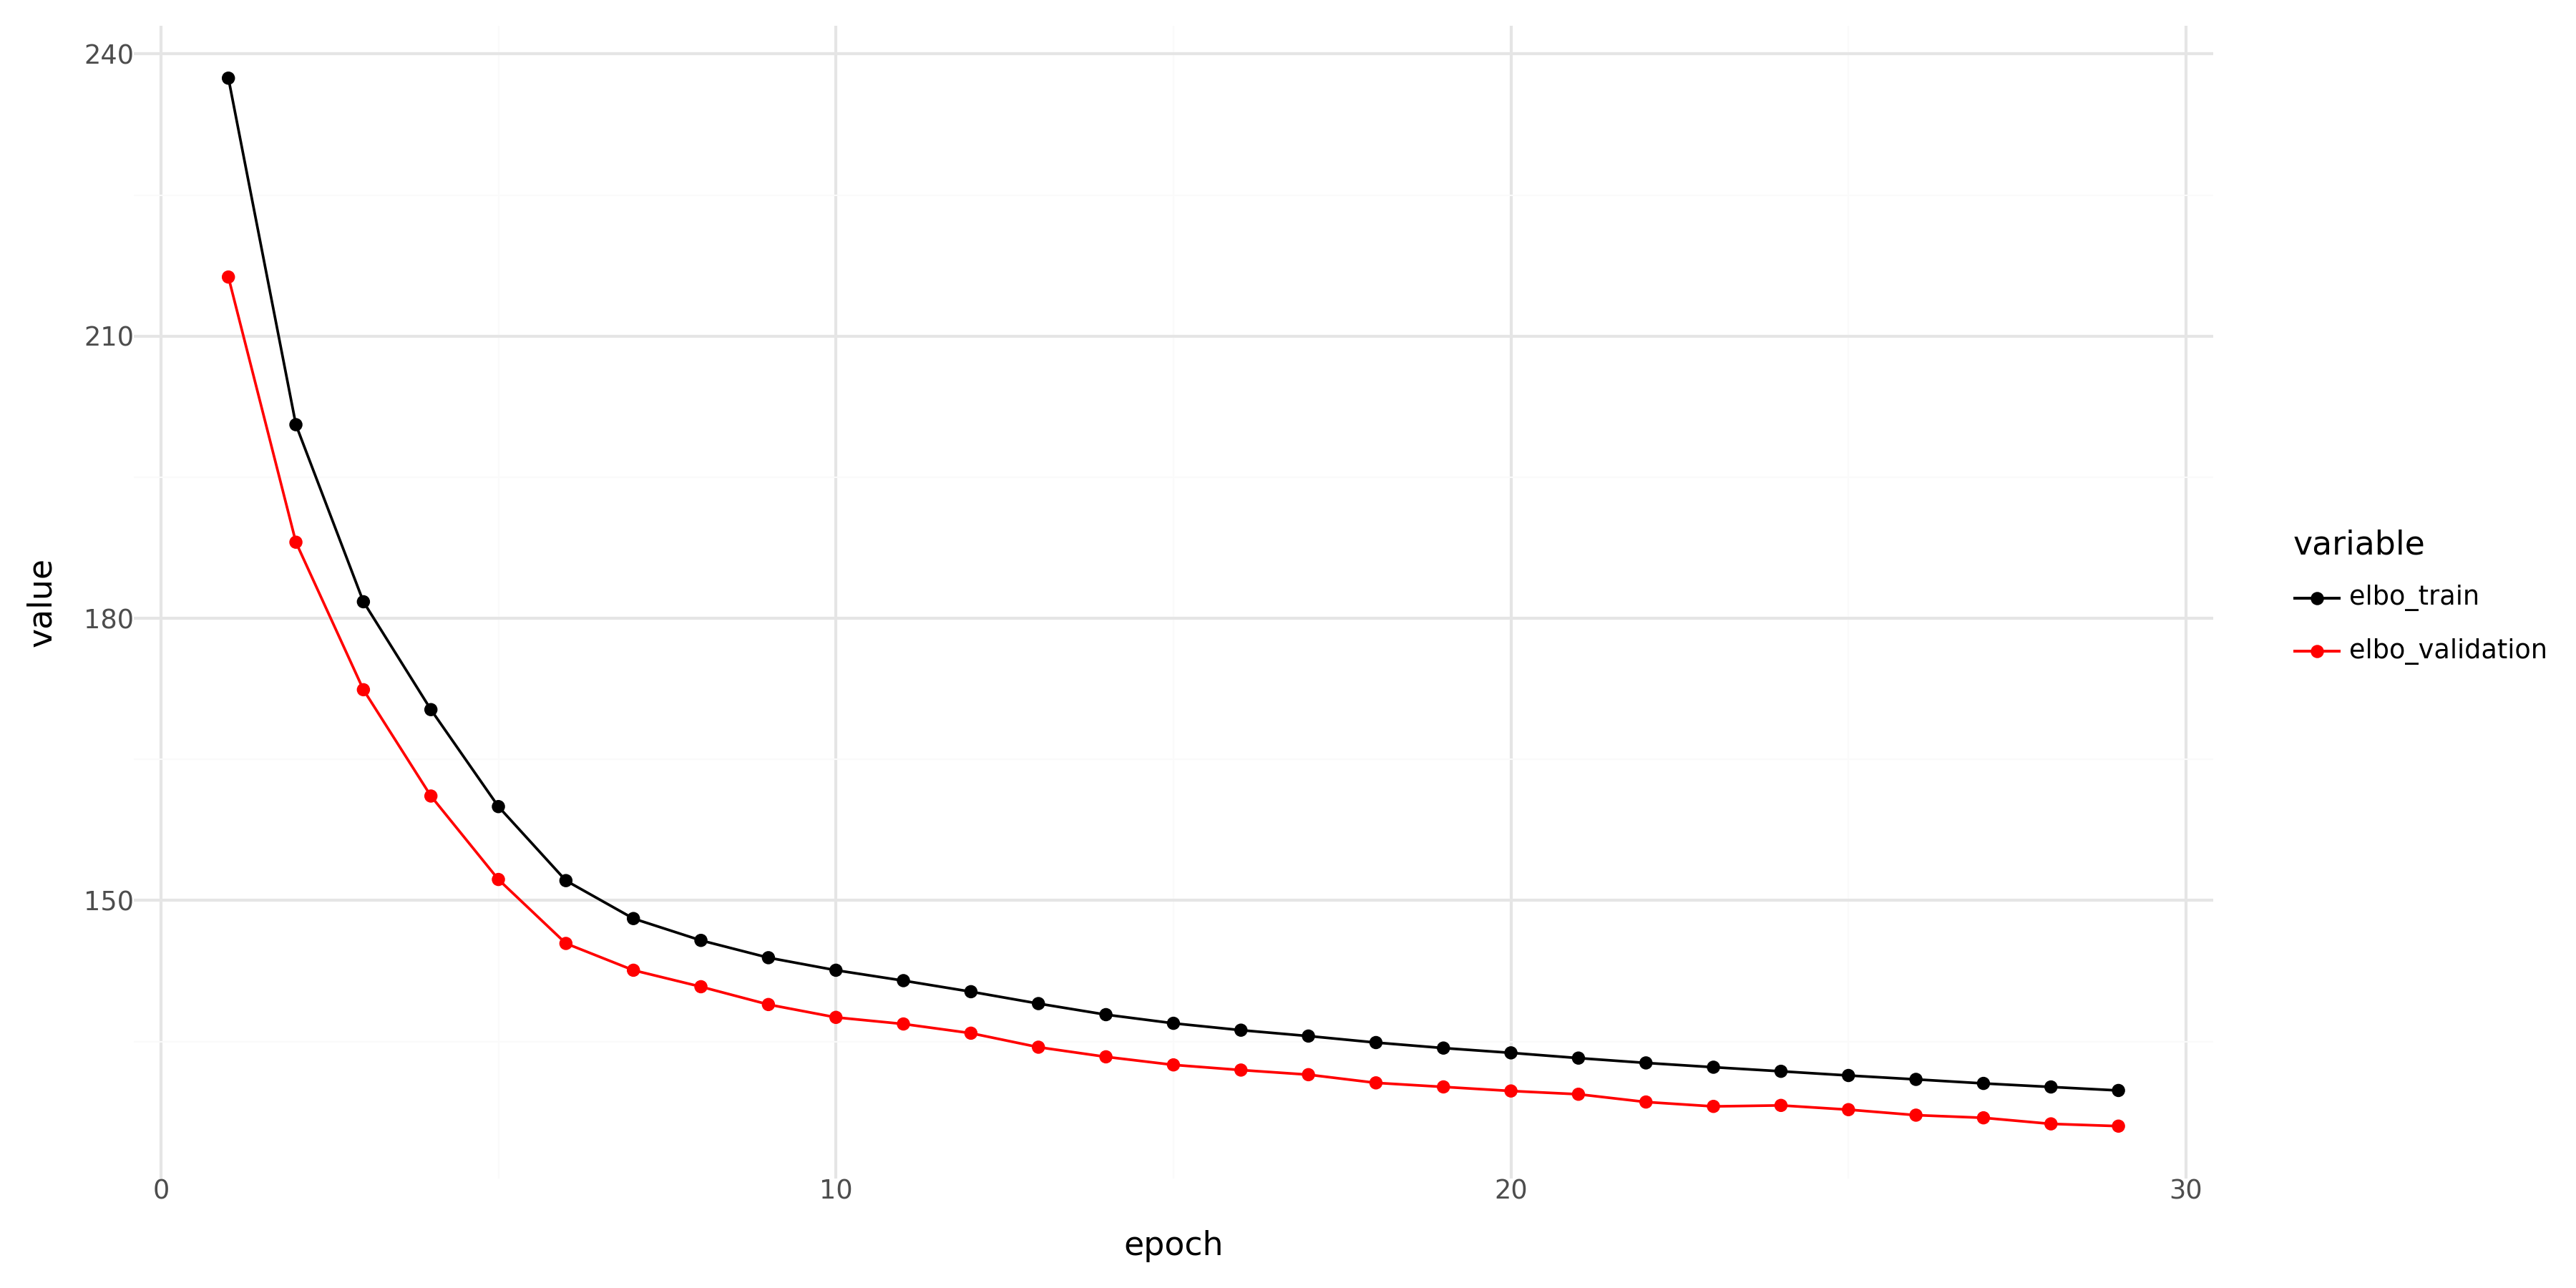

In [24]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

#### Label transfer with `scANVI` 

In [25]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [26]:
scanvi_model.train(50, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [0])

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 50/50: 100%|█████████████| 50/50 [51:11<00:00, 51.22s/it, v_num=1, train_loss_step=89.2, train_loss_epoch=89.1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|█████████████| 50/50 [51:11<00:00, 61.43s/it, v_num=1, train_loss_step=89.2, train_loss_epoch=89.1]


In [27]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [28]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

### Explore model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

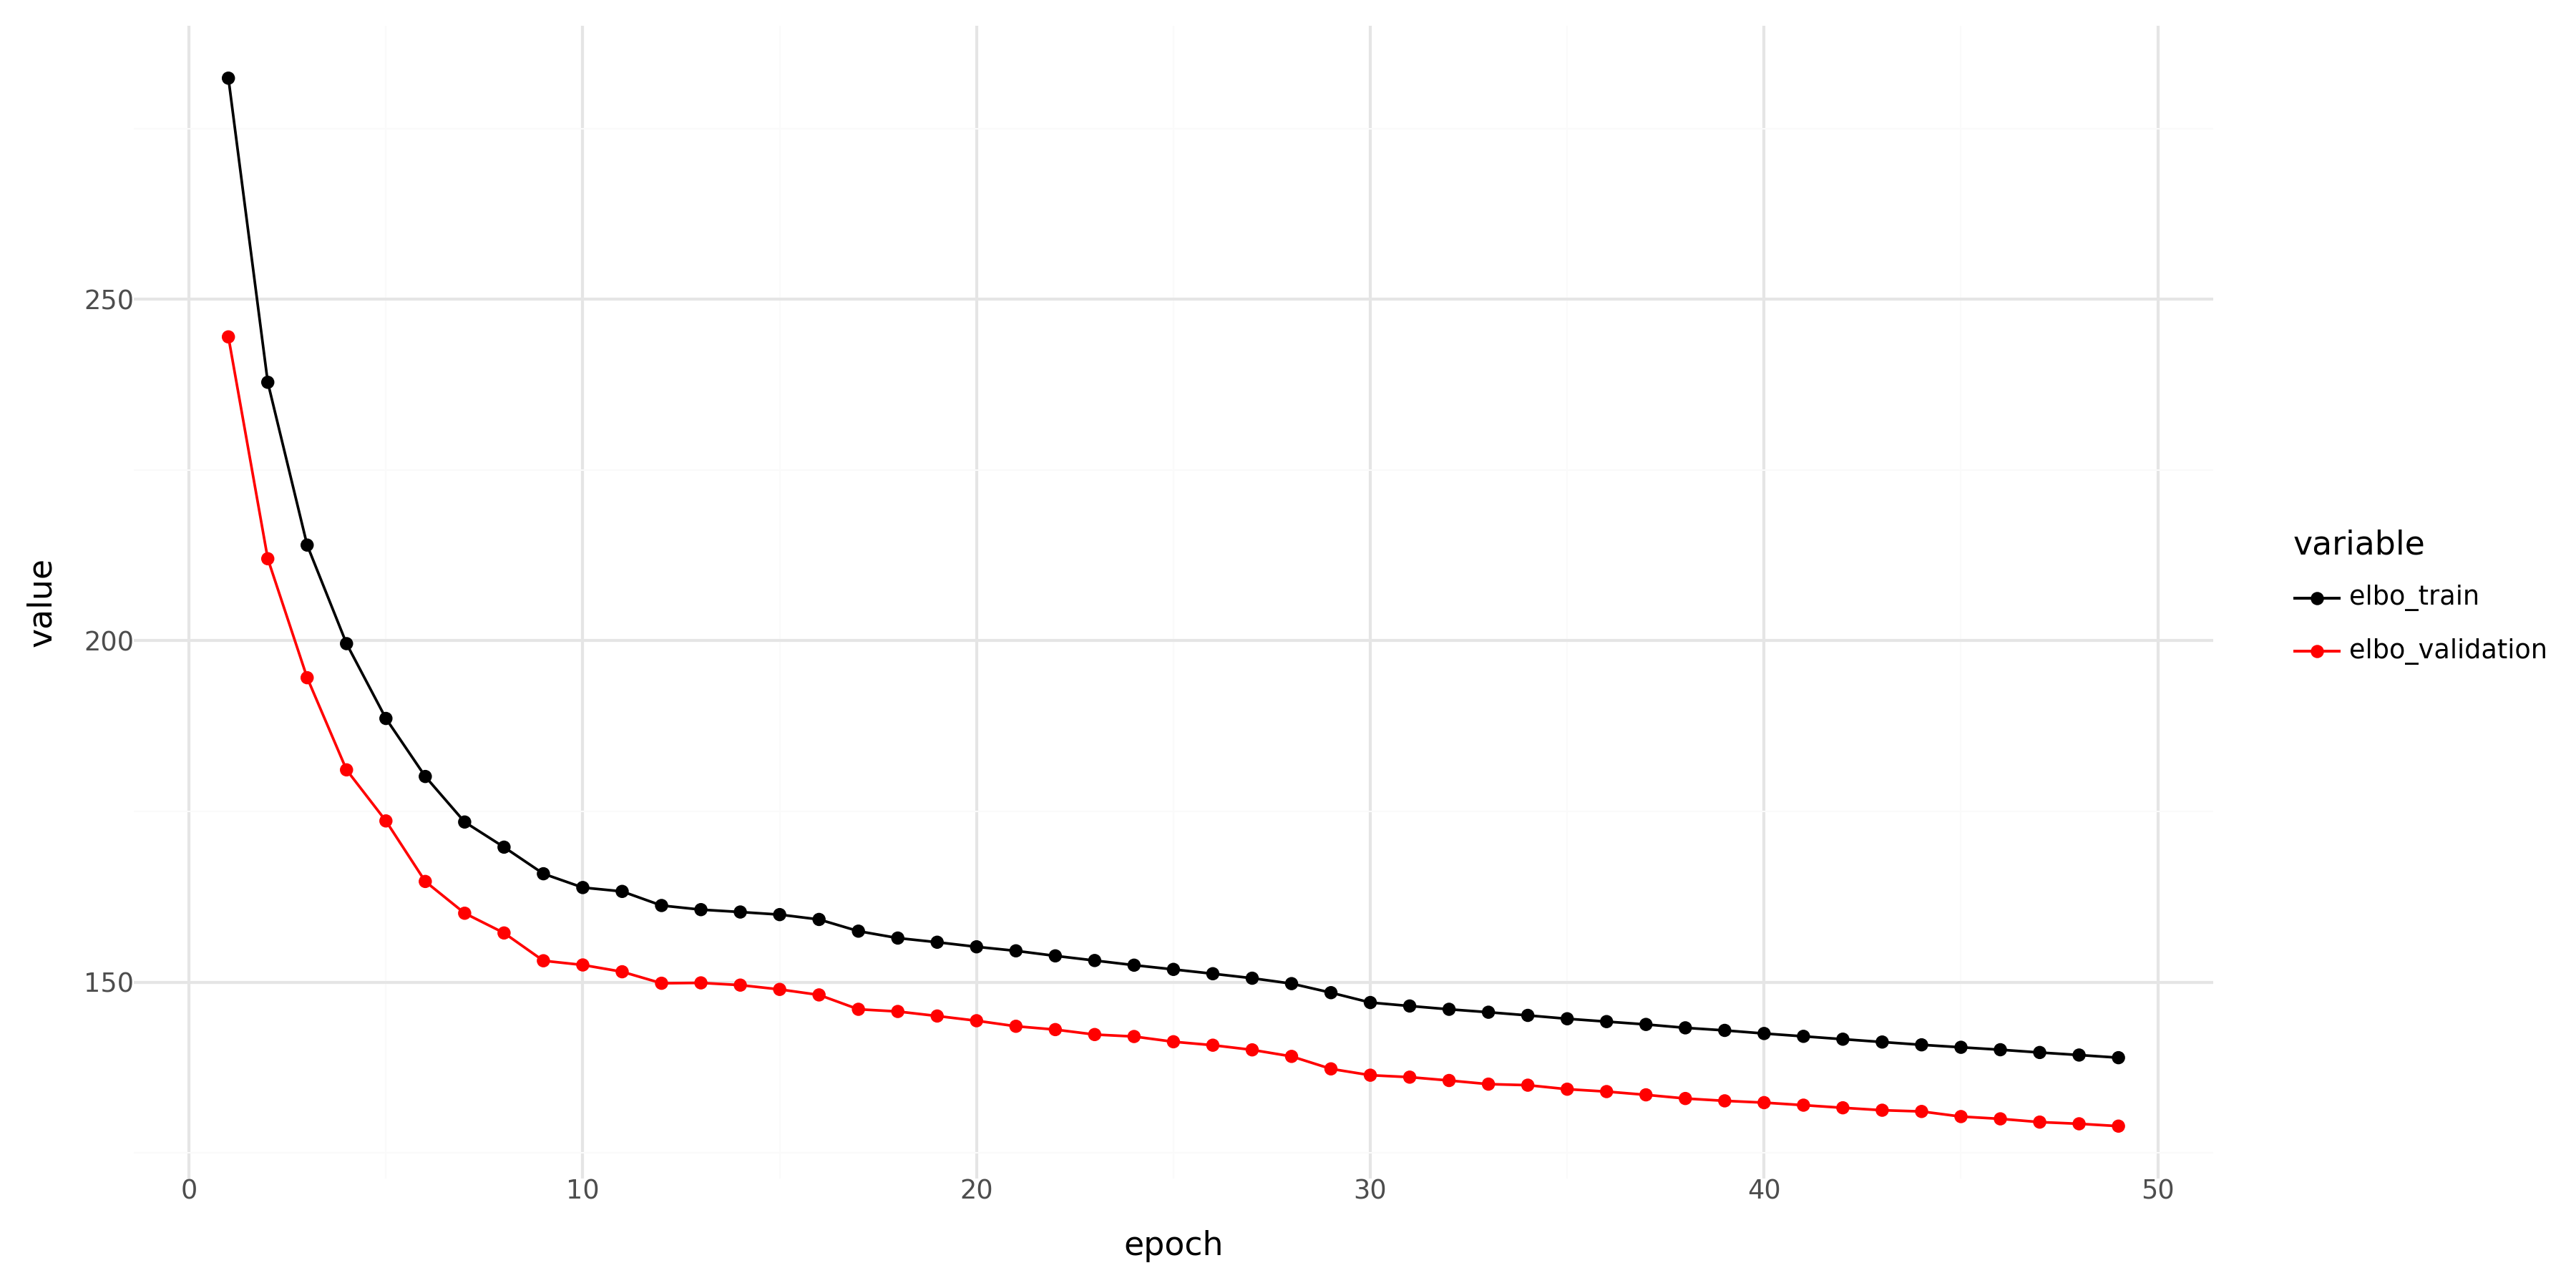

In [29]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [30]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_add_on_data_scANVI.h5ad')

+ Visualize dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

In [34]:
adata.obs['C_scANVI'].value_counts()

C_scANVI
Epithelial      256567
Mesenchymal      99192
Plasma cells     64819
T cells          51277
Myeloid          43271
Endothelial      24433
B cells          21460
Neuronal         10991
Name: count, dtype: int64

In [ ]:
sc.set_figure_params(dpi = 300, figsize=(10,7))
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'C_scANVI', 'Library_Preparation_Protocol', 'Donor_ID'], ncols = 3, frameon = False, size = 1)

#### Assess label transfer with scIB

In [1]:
import anndata as an
import scanpy as sc
from rich import print
import scib
import scib.metrics
import numpy as np
import torch
import faiss

/home/amaguza/miniforge3/envs/scib_env/lib/python3.9/site-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/home/amaguza/miniforge3/envs/scib_env/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
from scvi_colab import install
from scib_metrics.benchmark import Benchmarker

/home/amaguza/miniforge3/envs/scib_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import scib_metrics.nearest_neighbors
#from scib_metrics.nearest_neighbors import NeighborsOutput

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.6
scanpy      1.9.8
-----
PIL                         10.2.0
absl                        NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
brotli                      1.1.0
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.86
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
defusedxml                  0.7.1
deprecated                  1.2.14
etils                       1.5.2
exceptiongroup              1.2.0
executing                   2.0.1
faiss                       1.7.2
fastjsonschema              NA
fqdn                        NA
h5py

/home/amaguza/miniforge3/envs/scib_env/lib/python3.9/site-packages/session_info/main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
/home/amaguza/miniforge3/envs/scib_env/lib/python3.9/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [6]:
torch.cuda.is_available()

True

In [7]:
torch.set_float32_matmul_precision('medium')

+ Donor as a batch

In [8]:
adata_xenium = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_add_on_data_scANVI.h5ad')

In [9]:
def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsOutput(indices=indices, distances=np.sqrt(distances))

In [10]:
adata_xenium.obs['Donor_ID'].value_counts()

Xenium_donor_1    275822
A33 (414C)         36670
A34 (417C)         26214
197396             23499
180844             21053
A32 (411C)         20504
N10                15981
158108             14123
N51                13522
102141             12430
N46                 9773
N15                 8981
A39 (440C)          8769
A38 (432C)          8010
N18                 7308
A26 (386C)          7087
N20                 6605
N21                 5867
N11                 5536
N17                 5471
N13                 5330
A30 (398B)          4620
139073              4397
N16                 4358
152638              3631
101694              3535
110216              2609
106265              2101
N8                  2023
157844              1546
180749              1375
199129              1222
Wang_Donor_1         505
158160               348
N52                  224
N23                  199
Wang_Donor_2         155
N9                   132
N26                  106
N24                   85


In [11]:
sc.pp.neighbors(adata_xenium, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata_xenium, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:43)


In [12]:
adata_xenium.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_add_on_data_scANVI.h5ad')

In [ ]:
bm = Benchmarker(
    adata_xenium,
    batch_key='Donor_ID',
    label_key='C_scANVI',
    embedding_obsm_keys=['X_scANVI', 'X_scVI', 'X_pca', 'X_umap'],
    n_jobs=-1
)
bm.prepare(neighbor_computer=faiss_brute_force_nn)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

+ Library prep method as a batch

In [ ]:
adata.obs['Library_Preparation_Protocol'].value_counts()

In [ ]:
bm = Benchmarker(
    adata,
    batch_key='Library_Preparation_Protocol',
    label_key='C_scANVI',
    embedding_obsm_keys=['X_scANVI', 'X_scVI', 'X_pca', 'X_umap'],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)

+ Study as a batch

In [ ]:
adata.obs['Study_name'].value_counts()

In [ ]:
bm = Benchmarker(
    adata,
    batch_key='Study_name',
    label_key='C_scANVI',
    embedding_obsm_keys=['X_scANVI', 'X_scVI', 'X_pca', 'X_umap'],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
bm.plot_results_table(min_max_scale=False)